# Exploring Image Uniqueness with FiftyOne

During model training, the best results will be seen when training on *unique data samples*. For example, finding and removing similar samples in your dataset can avoid accidental concept imbalance that can bias the learning of your model. Or, if duplicate or near-duplicate data is present in both training and validation/test splits, evaluation results may not be reliable. Just to name a few.

This tutorial shows how FiftyOne can automatically find and remove near-duplicate images in your datasets and recommend the most unique samples in your data, enabling you to start your model training off right with a high-quality bootstrapped training set.

## Overview

In this walkthrough, we explore how FiftyOne's image uniqueness tool can be
used to analyze and extract insights from raw (unlabeled) datasets.

We'll cover the following concepts:

-   Loading a dataset from the FiftyOne Dataset Zoo
-   Applying FiftyOne's sample uniqueness algorithm to your dataset
-   Launching the FiftyOne App and visualizing/exploring your data
-   Identifying duplicate and near-duplicate images in your dataset
-   Identifying the most unique/representative images in your dataset

## Setup

If you haven't already, install FiftyOne:

In [ ]:
!pip install fiftyone

This tutorial requires either [Torchvision Datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) or [TensorFlow Datasets](https://www.tensorflow.org/datasets) to download the CIFAR-10 dataset used below.

You can, for example, install PyTorch as follows:

In [1]:
!pip install torch torchvision

## Part 1: Finding duplicate and near-duplicate images

A common problem in dataset creation is duplicated data. Although this could be
found using file hashing---as in the `image_deduplication` walkthrough---it is
less possible when small manipulations have occurred in the data. Even more
critical for workflows involving model training is the need to get as much
power out of each data samples as possible; near-duplicates, which are samples
that are exceptionally similar to one another, are intrinsically less valuable
for the training scenario. Let's see if we can find such duplicates and
near-duplicates in a common dataset: CIFAR-10.

### Load the dataset

Open a Python shell to begin. We will use the CIFAR-10 dataset, which is
available in the FiftyOne Dataset Zoo.

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

# Load the CIFAR-10 test split
# Downloads the dataset from the web if necessary
dataset = foz.load_zoo_dataset("cifar10", split="test")

Split 'test' already downloaded
Loading 'cifar10' split 'test'
 100% |████████████████████████| 10000/10000 [9.8s elapsed, 0s remaining, 1.0K samples/s]        
Dataset 'cifar10-test' created


### Compute uniqueness

Now we can process the entire dataset for uniqueness. This is a fairly
expensive operation, but should finish in a few minutes at most. We are
processing through all samples in the dataset, then building a representation
that relates the samples to each other. Finally, we analyze this representation
to output uniqueness.

In [2]:
import fiftyone.brain as fob

fob.compute_uniqueness(dataset)

Loading uniqueness model...
Preparing data...
Generating embeddings...
 100% |████████████████████████| 10000/10000 [54.3s elapsed, 0s remaining, 202.0 samples/s]      
Computing uniqueness...
Saving results...
 100% |████████████████████████| 10000/10000 [12.3s elapsed, 0s remaining, 846.1 samples/s]      
Uniqueness computation complete


The above method populates a `uniqueness` field on each sample that contains
the sample's uniqueness score. Let's confirm this by printing some information
about the dataset:

In [3]:
# Now the samples have a "uniqueness" field on them
print(dataset)

Name:           cifar10-test
Media type:     image
Num samples:    10000
Persistent:     False
Info:           {'classes': ['airplane', 'automobile', 'bird', ...]}
Tags:           ['test']
Sample fields:
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    uniqueness:   fiftyone.core.fields.FloatField


In [4]:
print(dataset.first())

<Sample: {
    'id': '5ff9f67f2fc771beda494449',
    'media_type': 'image',
    'filepath': '/home/ben/fiftyone/cifar10/test/data/00001.jpg',
    'tags': BaseList(['test']),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '5ff9f67f2fc771beda494448',
        'label': 'horse',
        'confidence': None,
        'logits': None,
    }>,
    'uniqueness': 0.5608251500841676,
}>


### Visualize to find duplicate and near-duplicate images

Now, let's visually inspect the least unique images in the dataset to see if
our dataset has any issues:


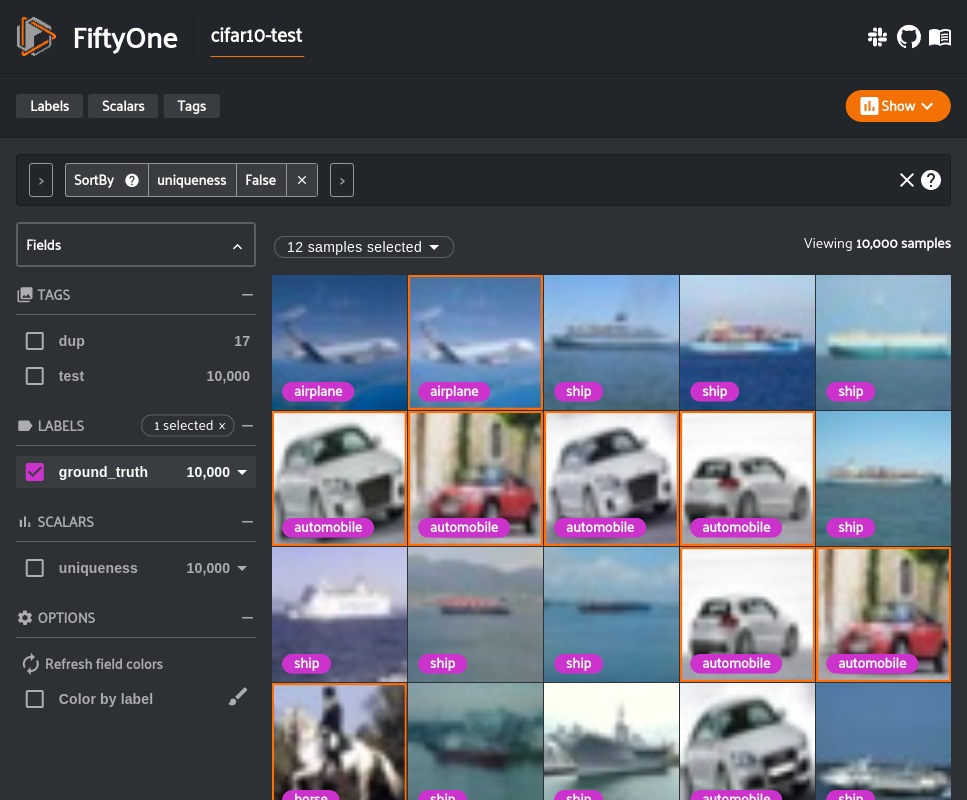

In [9]:
# Sort in increasing order of uniqueness (least unique first)
dups_view = dataset.sort_by("uniqueness")

# Launch the App
session = fo.launch_app(view=dups_view)

You will easily see some near-duplicates in the App. It surprised us that
there are duplicates in CIFAR-10, too!

Of course, in this scenario, near duplicates are identified from visual
inspection. So, how do we get the information out of FiftyOne and back into
your working environment. Easy! The `session` variable provides a bidirectional
bridge between the App and your Python environment. In this case, we will
use the `session.selected` bridge. So, in the App, click on some of the
duplicates and near-duplicates. Then, execute the following code in the Python
shell.


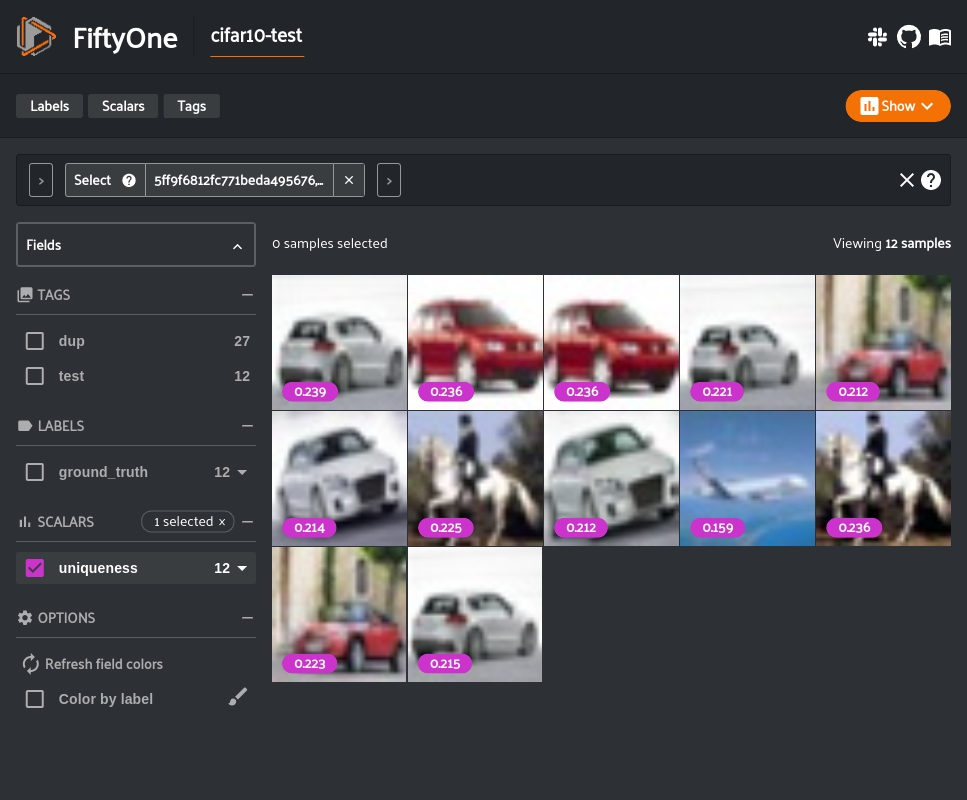

In [10]:
# Get currently selected images from App
dup_ids = session.selected

# Mark as duplicates
dups_view = dataset.select(dup_ids)
for sample in dups_view:
    sample.tags.append("dup")
    sample.save()

# Visualize duplicates-only in App
session.view = dups_view

And the App will only show these samples now. We can, of course access
the filepaths and other information about these samples programmatically so you
can act on the findings. But, let's do that at the end of Part 2 below!

## Part 2: Bootstrapping a dataset of unique samples

When building a dataset, it is important to create a diverse dataset with
unique and representative samples. Here, we explore FiftyOne's ability to help
identify the most unique samples in a raw dataset.

### Download some images

This walkthrough will process a directory of images and compute their
uniqueness. The first thing we need to do is get some images. Let's get some
images from Flickr, to keep this interesting!

You need a Flickr API key to do this. If you already have a Flickr API key,
then skip the next steps.

1. Go to <https://www.flickr.com/services/apps/create/>
2. Click on Request API Key.
   (<https://www.flickr.com/services/apps/create/apply/>) You will need to
   login (create account if needed, free).
3. Click on "Non-Commercial API Key" (this is just for a test usage) and fill
   in the information on the next page. You do not need to be very descriptive;
   your API will automatically appear on the following page.
4. Install the Flickr API:

In [8]:
!pip install flickrapi

You will also need to enable ETA's storage support to run this script, if you
haven't yet:

In [9]:
!pip install voxel51-eta[storage]

Next, let's download three sets of images to process together. I suggest using
three distinct object-nouns like "badger", "wolverine", and "kitten". For the
actual downloading, we will use the provided [query_flickr.py](https://raw.githubusercontent.com/voxel51/fiftyone/develop/docs/source/tutorials/query_flickr.py) script:

In [ ]:
from query_flickr import query_flickr

# Your credentials here
KEY = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
SECRET = "YYYYYYYYYYYYYYYY"

query_flickr(KEY, SECRET, "badger")
query_flickr(KEY, SECRET, "wolverine")
query_flickr(KEY, SECRET, "kitten")

The rest of this walkthrough assumes you've downloaded some images to your
local `.data/` directory.

### Load the data into FiftyOne

Let's now work through getting this data into FiftyOne and
working with it.

In [12]:
import fiftyone as fo

dataset = fo.Dataset.from_images_dir(
    "data", recursive=True, name="flickr-images"
)

print(dataset)
print(dataset.first())

 100% |████████████████████████████| 150/150 [125.0ms elapsed, 0s remaining, 1.2K samples/s]     
Name:           flickr-images
Media type:     image
Num samples:    150
Persistent:     False
Info:           {}
Tags:           []
Sample fields:
    filepath: fiftyone.core.fields.StringField
    tags:     fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
<Sample: {
    'id': '5ff9f8842fc771beda49e0a7',
    'media_type': 'image',
    'filepath': '/home/ben/code/fiftyone/docs/source/tutorials/data/badger/14271824861_122dfd2788_c.jpg',
    'tags': BaseList([]),
    'metadata': None,
}>


The above command uses factory method on the `Dataset` class to traverse a
directory of images (including subdirectories) and generate a dataset instance
in FiftyOne containing those images.

Note that the images are not loaded from disk, so this operation is fast. The
first argument is the path to the directory of images on disk, and the third is
a name for the dataset.

With the dataset loaded into FiftyOne, we can easily launch a App and
visualize it:


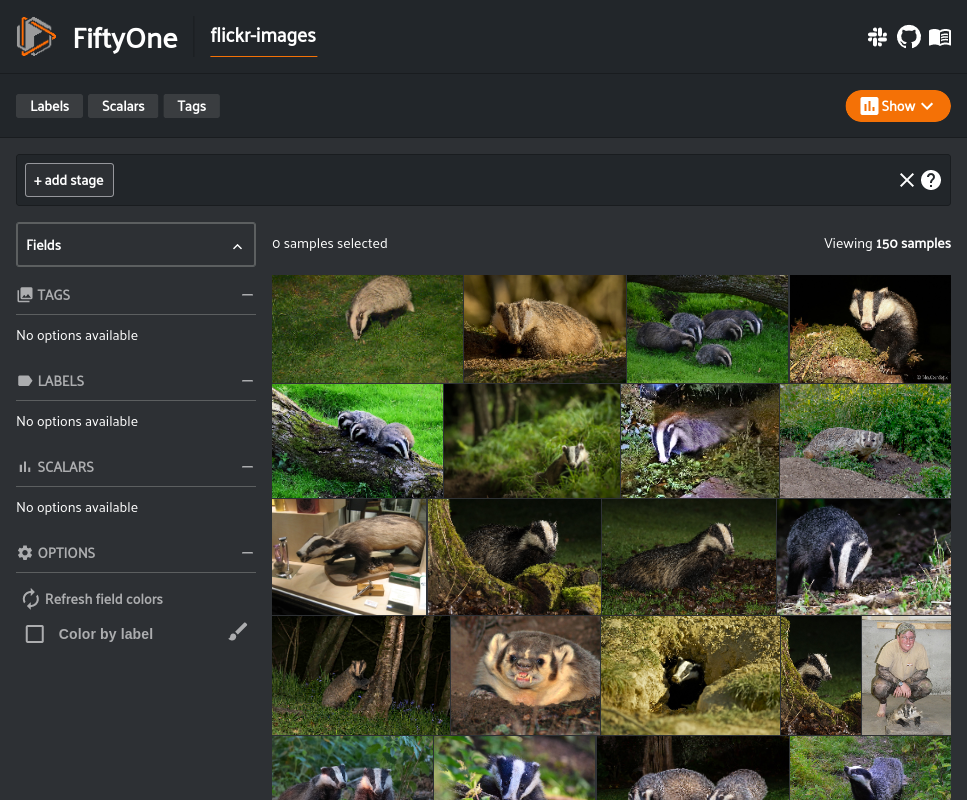

In [13]:
session = fo.launch_app(dataset)

Please refer to the [User Guides](https://voxel51.com/docs/fiftyone/user_guide/index.html) for more
useful things you can do with the dataset and App.

### Compute uniqueness and analyze

Now, let's analyze the data. For example, we may want to understand what are
the most unique images among the data as they may inform or harm model
training; we may want to discover duplicates or redundant samples.

Continuing in the same Python shell, let's compute and visualize uniqueness.

In [14]:
import fiftyone.brain as fob

fob.compute_uniqueness(dataset)

# Now the samples have a "uniqueness" field on them
print(dataset)

Loading uniqueness model...
Preparing data...
Generating embeddings...
 100% |████████████████████████████| 150/150 [1.1s elapsed, 0s remaining, 144.5 samples/s]         
Computing uniqueness...
Saving results...
 100% |████████████████████████████| 150/150 [274.6ms elapsed, 0s remaining, 546.3 samples/s]      
Uniqueness computation complete
Name:           flickr-images
Media type:     image
Num samples:    150
Persistent:     False
Info:           {}
Tags:           []
Sample fields:
    filepath:   fiftyone.core.fields.StringField
    tags:       fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    uniqueness: fiftyone.core.fields.FloatField


In [15]:
print(dataset.first())

<Sample: {
    'id': '5ff9f8842fc771beda49e0a7',
    'media_type': 'image',
    'filepath': '/home/ben/code/fiftyone/docs/source/tutorials/data/badger/14271824861_122dfd2788_c.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'uniqueness': 0.3202754931415438,
}>



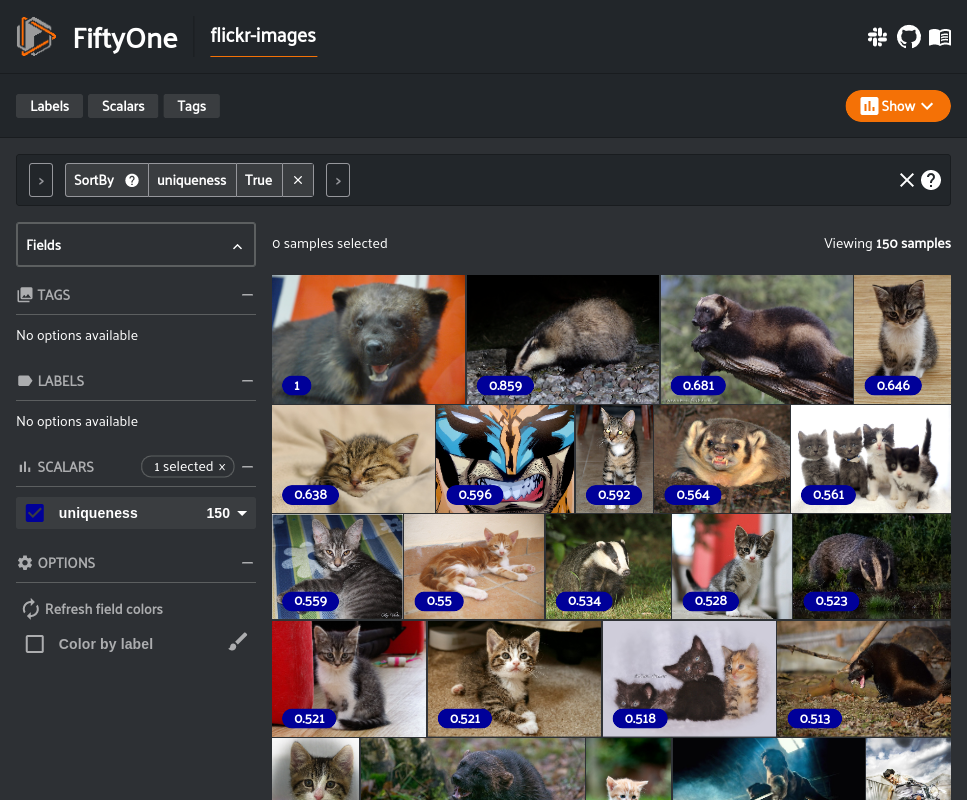

In [16]:
# Sort by uniqueness (most unique first)
rank_view = dataset.sort_by("uniqueness", reverse=True)

# Visualize in the App
session.view = rank_view

Now, just visualizing the samples is interesting, but we want more. We want to
get the most unique samples from our dataset so that we can use them in our
work. Let's do just that. In the same Python session, execute the following
code.

In [17]:
# Verify that the most unique sample has the maximal uniqueness of 1.0
print(rank_view.first())

# Extract paths to 10 most unique samples
ten_best = [x.filepath for x in rank_view.limit(10)]

for filepath in ten_best:
    print(filepath.split('/')[-1])

# Then you can do what you want with these.
# Output to csv or json, send images to your annotation team, seek additional
# similar data, etc.

<SampleView: {
    'id': '5ff9f8852fc771beda49e117',
    'media_type': 'image',
    'filepath': '/home/ben/code/fiftyone/docs/source/tutorials/data/wolverine/2428280852_6c77fe2877_c.jpg',
    'tags': BaseList([]),
    'metadata': None,
    'uniqueness': 1.0,
}>
2428280852_6c77fe2877_c.jpg
49733688496_b6fc5cde41_c.jpg
2843545851_6e1dc16dfc_c.jpg
7466201514_0a3c7d615a_c.jpg
6176873587_d0744926cb_c.jpg
33891021626_4cfe3bf1d2_c.jpg
8303699893_a7c14c04d3_c.jpg
388994554_34d60d1b18_c.jpg
8538740443_a587bfe75c_c.jpg
5880167199_906172bc50_c.jpg


In [19]:
session.freeze() # screenshot the active App for sharing